In [5]:
# 5fold

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    exp='002'
    wandb=True
    resume = None  # [None, 'auto', 'always']
    competition='PPPM'
    debug=False  # False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [7]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Thu Jun  2 09:56:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [8]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 3.1 MB/s 
CPU times: user 1.19 s, sys: 278 ms, total: 1.46 s
Wall time: 23.3 s


In [9]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [10]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume='auto',  # 'auto'
                     anonymous=anony)

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 71.5 MB/s 
     |████████████████████████████████| 145 kB 60.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [11]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [12]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [13]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [14]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [15]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

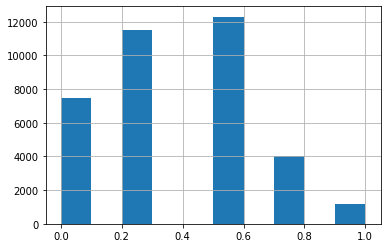

In [16]:
train['score'].hist()

In [17]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [18]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

587 146
587 146
586 147
586 147
586 147
2    7683
0    7592
3    7324
1    6995
4    6879
Name: fold, dtype: int64


In [19]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [20]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [23]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [24]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [26]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    # 'amp': amp.state_dict(),
                    'epoch': epoch,
                    'best_score': best_score},
                    checkpoint_path)
        # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [27]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'oof.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            torch.save({'fold': fold,
                        'oof_df': oof_df},
                        OUTPUT_DIR + 'oof.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1805] Elapsed 0m 1s (remain 38m 14s) Loss: 0.6714(0.6714) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1805] Elapsed 1m 36s (remain 27m 15s) Loss: 0.4784(0.6282) Grad: 86622.1562  LR: 0.00001999  
Epoch: [1][200/1805] Elapsed 3m 12s (remain 25m 33s) Loss: 0.5206(0.6067) Grad: 53969.3359  LR: 0.00001996  
Epoch: [1][300/1805] Elapsed 4m 47s (remain 23m 56s) Loss: 0.5828(0.5967) Grad: 103956.6875  LR: 0.00001991  
Epoch: [1][400/1805] Elapsed 6m 22s (remain 22m 19s) Loss: 0.4832(0.5878) Grad: 29455.1074  LR: 0.00001985  
Epoch: [1][500/1805] Elapsed 7m 57s (remain 20m 43s) Loss: 0.6774(0.5828) Grad: 86724.0547  LR: 0.00001976  
Epoch: [1][600/1805] Elapsed 9m 33s (remain 19m 8s) Loss: 0.5994(0.5799) Grad: 40855.3008  LR: 0.00001966  
Epoch: [1][700/1805] Elapsed 11m 8s (remain 17m 32s) Loss: 0.5443(0.5750) Grad: 34779.0117  LR: 0.00001954  
Epoch: [1][800/1805] Elapsed 12m 43s (remain 15m 57s) Loss: 0.5153(0.5725) Grad: 19704.9492  LR: 0.00001940  
Epoch: [1][900/1805] Elapsed

Epoch 1 - avg_train_loss: 0.5577  avg_val_loss: 0.5492  time: 1858s
Epoch 1 - Score: 0.8033


EVAL: [474/475] Elapsed 2m 18s (remain 0m 0s) Loss: 0.3705(0.5492) 


Epoch 1 - Save Best Score: 0.8033 Model


Epoch: [2][0/1805] Elapsed 0m 1s (remain 39m 45s) Loss: 0.2957(0.2957) Grad: 81899.7109  LR: 0.00001707  
Epoch: [2][100/1805] Elapsed 1m 38s (remain 27m 35s) Loss: 0.6520(0.5196) Grad: 164252.1875  LR: 0.00001675  
Epoch: [2][200/1805] Elapsed 3m 13s (remain 25m 41s) Loss: 0.6422(0.5164) Grad: 38086.9883  LR: 0.00001643  
Epoch: [2][300/1805] Elapsed 4m 48s (remain 23m 59s) Loss: 0.4945(0.5151) Grad: 105854.0859  LR: 0.00001609  
Epoch: [2][400/1805] Elapsed 6m 23s (remain 22m 21s) Loss: 0.4311(0.5171) Grad: 62983.1406  LR: 0.00001574  
Epoch: [2][500/1805] Elapsed 7m 58s (remain 20m 44s) Loss: 0.4461(0.5176) Grad: 109808.8672  LR: 0.00001537  
Epoch: [2][600/1805] Elapsed 9m 33s (remain 19m 8s) Loss: 0.5300(0.5189) Grad: 57256.8594  LR: 0.00001500  
Epoch: [2][700/1805] Elapsed 11m 8s (remain 17m 32s) Loss: 0.5096(0.5190) Grad: 71186.0703  LR: 0.00001462  
Epoch: [2][800/1805] Elapsed 12m 43s (remain 15m 56s) Loss: 0.4994(0.5207) Grad: 51951.5547  LR: 0.00001423  
Epoch: [2][900/1805

Epoch 2 - avg_train_loss: 0.5167  avg_val_loss: 0.5654  time: 1857s
Epoch 2 - Score: 0.8135


EVAL: [474/475] Elapsed 2m 18s (remain 0m 0s) Loss: 0.3210(0.5654) 


Epoch 2 - Save Best Score: 0.8135 Model


Epoch: [3][0/1805] Elapsed 0m 1s (remain 43m 22s) Loss: 0.4810(0.4810) Grad: 23186.2988  LR: 0.00001000  
Epoch: [3][100/1805] Elapsed 1m 38s (remain 27m 38s) Loss: 0.3971(0.5047) Grad: 41119.4023  LR: 0.00000956  
Epoch: [3][200/1805] Elapsed 3m 13s (remain 25m 44s) Loss: 0.4017(0.5015) Grad: 50313.0742  LR: 0.00000913  
Epoch: [3][300/1805] Elapsed 4m 48s (remain 24m 3s) Loss: 0.5408(0.5023) Grad: 47002.5117  LR: 0.00000869  
Epoch: [3][400/1805] Elapsed 6m 24s (remain 22m 25s) Loss: 0.4734(0.5048) Grad: 144709.4531  LR: 0.00000826  
Epoch: [3][500/1805] Elapsed 7m 59s (remain 20m 47s) Loss: 0.6232(0.5056) Grad: 227295.7031  LR: 0.00000784  
Epoch: [3][600/1805] Elapsed 9m 34s (remain 19m 11s) Loss: 0.5696(0.5073) Grad: 44271.2188  LR: 0.00000741  
Epoch: [3][700/1805] Elapsed 11m 10s (remain 17m 35s) Loss: 0.5458(0.5073) Grad: 464240.9688  LR: 0.00000700  
Epoch: [3][800/1805] Elapsed 12m 45s (remain 15m 59s) Loss: 0.6359(0.5067) Grad: 77695.8672  LR: 0.00000658  
Epoch: [3][900/180

Epoch 3 - avg_train_loss: 0.5053  avg_val_loss: 0.5621  time: 1859s
Epoch 3 - Score: 0.8207


EVAL: [474/475] Elapsed 2m 18s (remain 0m 0s) Loss: 0.3191(0.5621) 


Epoch 3 - Save Best Score: 0.8207 Model


Epoch: [4][0/1805] Elapsed 0m 1s (remain 38m 28s) Loss: 0.4384(0.4384) Grad: 47500.6328  LR: 0.00000293  
Epoch: [4][100/1805] Elapsed 1m 37s (remain 27m 30s) Loss: 0.4824(0.5052) Grad: 39898.2578  LR: 0.00000263  
Epoch: [4][200/1805] Elapsed 3m 12s (remain 25m 39s) Loss: 0.5196(0.5041) Grad: 315402.0938  LR: 0.00000234  
Epoch: [4][300/1805] Elapsed 4m 48s (remain 23m 59s) Loss: 0.5441(0.5011) Grad: 52865.2383  LR: 0.00000207  
Epoch: [4][400/1805] Elapsed 6m 22s (remain 22m 20s) Loss: 0.5094(0.4996) Grad: 671513.4375  LR: 0.00000181  
Epoch: [4][500/1805] Elapsed 7m 57s (remain 20m 44s) Loss: 0.5618(0.4980) Grad: 270599.0625  LR: 0.00000157  
Epoch: [4][600/1805] Elapsed 9m 32s (remain 19m 7s) Loss: 0.5899(0.4989) Grad: 33359.6055  LR: 0.00000134  
Epoch: [4][700/1805] Elapsed 11m 7s (remain 17m 32s) Loss: 0.5166(0.4978) Grad: 11046.5840  LR: 0.00000113  
Epoch: [4][800/1805] Elapsed 12m 42s (remain 15m 56s) Loss: 0.4340(0.4974) Grad: 34861.4453  LR: 0.00000094  
Epoch: [4][900/1805

Epoch 4 - avg_train_loss: 0.4986  avg_val_loss: 0.5699  time: 1857s
Epoch 4 - Score: 0.8194


EVAL: [474/475] Elapsed 2m 18s (remain 0m 0s) Loss: 0.3187(0.5699) 


========== fold: 0 result ==========
Score: 0.8207
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1842] Elapsed 0m 1s (remain 42m 21s) Loss: 0.7476(0.7476) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1842] Elapsed 1m 37s (remain 28m 2s) Loss: 0.6810(0.6559) Grad: 46175.1562  LR: 0.00001999  
Epoch: [1][200/1842] Elapsed 3m 12s (remain 26m 14s) Loss: 0.6189(0.6301) Grad: 21203.5898  LR: 0.00001996  
Epoch: [1][300/1842] Elapsed 4m 47s (remain 24m 33s) Loss: 0.5454(0.6127) Grad: 42854.8438  LR: 0.00001992  
Epoch: [1][400/1842] Elapsed 6m 22s (remain 22m 56s) Loss: 0.5529(0.6035) Grad: 9292.7100  LR: 0.00001985  
Epoch: [1][500/1842] Elapsed 7m 58s (remain 21m 19s) Loss: 0.4905(0.5970) Grad: 7643.5566  LR: 0.00001977  
Epoch: [1][600/1842] Elapsed 9m 33s (remain 19m 44s) Loss: 0.6405(0.5919) Grad: 15226.8086  LR: 0.00001967  
Epoch: [1][700/1842] Elapsed 11m 8s (remain 18m 8s) Loss: 0.6355(0.5876) Grad: 26616.4512  LR: 0.00001956  
Epoch: [1][800/1842] Elapsed 12m 43s (remain 16m 32s) Loss: 0.5791(0.5825) Grad: 23524.2363  LR: 0.00001942  
Epoch: [1][900/1842] Elapsed 14m

Epoch 1 - avg_train_loss: 0.5610  avg_val_loss: 0.5493  time: 1881s
Epoch 1 - Score: 0.8045


EVAL: [437/438] Elapsed 2m 7s (remain 0m 0s) Loss: 0.6626(0.5493) 


Epoch 1 - Save Best Score: 0.8045 Model


Epoch: [2][0/1842] Elapsed 0m 1s (remain 39m 20s) Loss: 0.4762(0.4762) Grad: 38400.0312  LR: 0.00001707  
Epoch: [2][100/1842] Elapsed 1m 38s (remain 28m 10s) Loss: 0.5351(0.5224) Grad: 273656.1250  LR: 0.00001676  
Epoch: [2][200/1842] Elapsed 3m 13s (remain 26m 20s) Loss: 0.5794(0.5218) Grad: 88813.0703  LR: 0.00001644  
Epoch: [2][300/1842] Elapsed 4m 48s (remain 24m 37s) Loss: 0.5542(0.5207) Grad: 89348.7031  LR: 0.00001611  
Epoch: [2][400/1842] Elapsed 6m 24s (remain 23m 1s) Loss: 0.4740(0.5202) Grad: 84627.4922  LR: 0.00001577  
Epoch: [2][500/1842] Elapsed 8m 0s (remain 21m 25s) Loss: 0.5024(0.5195) Grad: 132352.3750  LR: 0.00001541  
Epoch: [2][600/1842] Elapsed 9m 35s (remain 19m 47s) Loss: 0.4675(0.5177) Grad: 34041.8164  LR: 0.00001505  
Epoch: [2][700/1842] Elapsed 11m 10s (remain 18m 11s) Loss: 0.3616(0.5168) Grad: 62561.6523  LR: 0.00001468  
Epoch: [2][800/1842] Elapsed 12m 46s (remain 16m 35s) Loss: 0.5495(0.5145) Grad: 69642.5391  LR: 0.00001430  
Epoch: [2][900/1842]

Epoch 2 - avg_train_loss: 0.5157  avg_val_loss: 0.5643  time: 1891s
Epoch 2 - Score: 0.8175


EVAL: [437/438] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6533(0.5643) 


Epoch 2 - Save Best Score: 0.8175 Model


Epoch: [3][0/1842] Elapsed 0m 1s (remain 41m 9s) Loss: 0.5074(0.5074) Grad: 30814.4492  LR: 0.00001000  
Epoch: [3][100/1842] Elapsed 1m 36s (remain 27m 50s) Loss: 0.4110(0.5010) Grad: 97734.5156  LR: 0.00000957  
Epoch: [3][200/1842] Elapsed 3m 12s (remain 26m 10s) Loss: 0.5222(0.5058) Grad: 50749.8047  LR: 0.00000915  
Epoch: [3][300/1842] Elapsed 4m 48s (remain 24m 35s) Loss: 0.4740(0.5059) Grad: 57228.7500  LR: 0.00000872  
Epoch: [3][400/1842] Elapsed 6m 24s (remain 23m 0s) Loss: 0.4400(0.5081) Grad: 52757.9922  LR: 0.00000830  
Epoch: [3][500/1842] Elapsed 7m 59s (remain 21m 23s) Loss: 0.5483(0.5076) Grad: 85461.3984  LR: 0.00000788  
Epoch: [3][600/1842] Elapsed 9m 35s (remain 19m 47s) Loss: 0.4000(0.5067) Grad: 75005.6484  LR: 0.00000747  
Epoch: [3][700/1842] Elapsed 11m 10s (remain 18m 11s) Loss: 0.4730(0.5072) Grad: 50105.6445  LR: 0.00000706  
Epoch: [3][800/1842] Elapsed 12m 46s (remain 16m 35s) Loss: 0.5734(0.5067) Grad: 77111.9453  LR: 0.00000665  
Epoch: [3][900/1842] E

Epoch 3 - avg_train_loss: 0.5064  avg_val_loss: 0.5736  time: 1892s
Epoch 3 - Score: 0.8183
Epoch 3 - Save Best Score: 0.8183 Model


Epoch: [4][0/1842] Elapsed 0m 1s (remain 43m 9s) Loss: 0.5475(0.5475) Grad: 62354.5000  LR: 0.00000293  
Epoch: [4][100/1842] Elapsed 1m 37s (remain 27m 56s) Loss: 0.5399(0.5013) Grad: 39246.8086  LR: 0.00000263  
Epoch: [4][200/1842] Elapsed 3m 13s (remain 26m 18s) Loss: 0.4922(0.5042) Grad: 37662.3516  LR: 0.00000235  
Epoch: [4][300/1842] Elapsed 4m 48s (remain 24m 39s) Loss: 0.4449(0.5009) Grad: 53071.4414  LR: 0.00000208  
Epoch: [4][400/1842] Elapsed 6m 24s (remain 23m 2s) Loss: 0.4242(0.5014) Grad: 31050.7520  LR: 0.00000183  
Epoch: [4][500/1842] Elapsed 8m 0s (remain 21m 27s) Loss: 0.5080(0.5022) Grad: 56885.0469  LR: 0.00000159  
Epoch: [4][600/1842] Elapsed 9m 36s (remain 19m 51s) Loss: 0.5601(0.5022) Grad: 55405.8164  LR: 0.00000137  
Epoch: [4][700/1842] Elapsed 11m 12s (remain 18m 15s) Loss: 0.4390(0.5041) Grad: 54168.0039  LR: 0.00000116  
Epoch: [4][800/1842] Elapsed 12m 48s (remain 16m 39s) Loss: 0.4846(0.5032) Grad: 27589.7207  LR: 0.00000097  
Epoch: [4][900/1842] El

Epoch 4 - avg_train_loss: 0.5004  avg_val_loss: 0.5780  time: 1895s
Epoch 4 - Score: 0.8180


EVAL: [437/438] Elapsed 2m 9s (remain 0m 0s) Loss: 0.6544(0.5780) 


========== fold: 1 result ==========
Score: 0.8183
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1799] Elapsed 0m 1s (remain 39m 35s) Loss: 0.7087(0.7087) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1799] Elapsed 1m 37s (remain 27m 12s) Loss: 0.5496(0.6408) Grad: 45214.3711  LR: 0.00001999  
Epoch: [1][200/1799] Elapsed 3m 12s (remain 25m 32s) Loss: 0.5211(0.6139) Grad: 64968.1719  LR: 0.00001996  
Epoch: [1][300/1799] Elapsed 4m 48s (remain 23m 55s) Loss: 0.5699(0.5969) Grad: 35493.9609  LR: 0.00001991  
Epoch: [1][400/1799] Elapsed 6m 24s (remain 22m 19s) Loss: 0.5774(0.5893) Grad: 51714.2930  LR: 0.00001985  
Epoch: [1][500/1799] Elapsed 7m 59s (remain 20m 43s) Loss: 0.6828(0.5839) Grad: 97254.3203  LR: 0.00001976  
Epoch: [1][600/1799] Elapsed 9m 35s (remain 19m 7s) Loss: 0.5676(0.5784) Grad: 207448.3906  LR: 0.00001966  
Epoch: [1][700/1799] Elapsed 11m 11s (remain 17m 31s) Loss: 0.5131(0.5755) Grad: 46072.1250  LR: 0.00001954  
Epoch: [1][800/1799] Elapsed 12m 46s (remain 15m 55s) Loss: 0.6284(0.5748) Grad: 20717.2988  LR: 0.00001939  
Epoch: [1][900/1799] Elapse

Epoch 1 - avg_train_loss: 0.5613  avg_val_loss: 0.5550  time: 1864s
Epoch 1 - Score: 0.8110
Epoch 1 - Save Best Score: 0.8110 Model


Epoch: [2][0/1799] Elapsed 0m 1s (remain 56m 19s) Loss: 0.5961(0.5961) Grad: 87644.1875  LR: 0.00001707  
Epoch: [2][100/1799] Elapsed 1m 37s (remain 27m 22s) Loss: 0.5604(0.5354) Grad: 13510.5361  LR: 0.00001675  
Epoch: [2][200/1799] Elapsed 3m 13s (remain 25m 38s) Loss: 0.5328(0.5240) Grad: 20310.3496  LR: 0.00001643  
Epoch: [2][300/1799] Elapsed 4m 49s (remain 23m 59s) Loss: 0.5746(0.5243) Grad: 51427.6133  LR: 0.00001608  
Epoch: [2][400/1799] Elapsed 6m 24s (remain 22m 21s) Loss: 0.6129(0.5231) Grad: 96375.6250  LR: 0.00001573  
Epoch: [2][500/1799] Elapsed 8m 0s (remain 20m 44s) Loss: 0.5336(0.5219) Grad: 19271.1562  LR: 0.00001537  
Epoch: [2][600/1799] Elapsed 9m 36s (remain 19m 8s) Loss: 0.4320(0.5218) Grad: 34505.2695  LR: 0.00001500  
Epoch: [2][700/1799] Elapsed 11m 11s (remain 17m 32s) Loss: 0.5274(0.5207) Grad: 12147.6865  LR: 0.00001461  
Epoch: [2][800/1799] Elapsed 12m 47s (remain 15m 56s) Loss: 0.4860(0.5196) Grad: 22223.8105  LR: 0.00001422  
Epoch: [2][900/1799] E

Epoch 2 - avg_train_loss: 0.5183  avg_val_loss: 0.5537  time: 1866s
Epoch 2 - Score: 0.8329


EVAL: [480/481] Elapsed 2m 22s (remain 0m 0s) Loss: 0.2467(0.5537) 


Epoch 2 - Save Best Score: 0.8329 Model


Epoch: [3][0/1799] Elapsed 0m 1s (remain 39m 53s) Loss: 0.4872(0.4872) Grad: 36446.4453  LR: 0.00001000  
Epoch: [3][100/1799] Elapsed 1m 37s (remain 27m 14s) Loss: 0.4783(0.5022) Grad: 29758.5293  LR: 0.00000956  
Epoch: [3][200/1799] Elapsed 3m 15s (remain 25m 52s) Loss: 0.5845(0.5092) Grad: 55879.7656  LR: 0.00000913  
Epoch: [3][300/1799] Elapsed 4m 51s (remain 24m 8s) Loss: 0.4562(0.5087) Grad: 116077.7734  LR: 0.00000869  
Epoch: [3][400/1799] Elapsed 6m 26s (remain 22m 27s) Loss: 0.5428(0.5088) Grad: 45311.1914  LR: 0.00000826  
Epoch: [3][500/1799] Elapsed 8m 2s (remain 20m 48s) Loss: 0.5947(0.5089) Grad: 77236.1641  LR: 0.00000783  
Epoch: [3][600/1799] Elapsed 9m 37s (remain 19m 11s) Loss: 0.5513(0.5056) Grad: 95147.2656  LR: 0.00000741  
Epoch: [3][700/1799] Elapsed 11m 13s (remain 17m 34s) Loss: 0.4239(0.5053) Grad: 12113.4473  LR: 0.00000699  
Epoch: [3][800/1799] Elapsed 12m 48s (remain 15m 57s) Loss: 0.5404(0.5059) Grad: 27061.5703  LR: 0.00000658  
Epoch: [3][900/1799] 

Epoch 3 - avg_train_loss: 0.5040  avg_val_loss: 0.5545  time: 1864s
Epoch 3 - Score: 0.8353


EVAL: [480/481] Elapsed 2m 21s (remain 0m 0s) Loss: 0.2354(0.5545) 


Epoch 3 - Save Best Score: 0.8353 Model


Epoch: [4][0/1799] Elapsed 0m 1s (remain 49m 40s) Loss: 0.5537(0.5537) Grad: 55640.6680  LR: 0.00000293  
Epoch: [4][100/1799] Elapsed 1m 39s (remain 27m 46s) Loss: 0.5429(0.4838) Grad: 32589.7773  LR: 0.00000263  
Epoch: [4][200/1799] Elapsed 3m 14s (remain 25m 46s) Loss: 0.4403(0.4979) Grad: 53385.5625  LR: 0.00000234  
Epoch: [4][300/1799] Elapsed 4m 49s (remain 24m 2s) Loss: 0.4096(0.4982) Grad: 189444.5156  LR: 0.00000207  
Epoch: [4][400/1799] Elapsed 6m 25s (remain 22m 23s) Loss: 0.6128(0.4978) Grad: 53216.8867  LR: 0.00000181  
Epoch: [4][500/1799] Elapsed 8m 0s (remain 20m 46s) Loss: 0.5375(0.5011) Grad: 241215.5156  LR: 0.00000157  
Epoch: [4][600/1799] Elapsed 9m 36s (remain 19m 8s) Loss: 0.5616(0.5009) Grad: 126137.1016  LR: 0.00000134  
Epoch: [4][700/1799] Elapsed 11m 12s (remain 17m 32s) Loss: 0.4822(0.5001) Grad: 28013.8613  LR: 0.00000113  
Epoch: [4][800/1799] Elapsed 12m 47s (remain 15m 56s) Loss: 0.5304(0.4996) Grad: 158880.1562  LR: 0.00000094  
Epoch: [4][900/1799

Epoch 4 - avg_train_loss: 0.4978  avg_val_loss: 0.5609  time: 1862s


EVAL: [480/481] Elapsed 2m 21s (remain 0m 0s) Loss: 0.2343(0.5609) 


Epoch 4 - Score: 0.8339
========== fold: 2 result ==========
Score: 0.8353
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1821] Elapsed 0m 1s (remain 43m 21s) Loss: 0.8611(0.8611) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1821] Elapsed 1m 38s (remain 27m 53s) Loss: 0.5696(0.6513) Grad: 23552.6934  LR: 0.00001999  
Epoch: [1][200/1821] Elapsed 3m 13s (remain 26m 1s) Loss: 0.6160(0.6170) Grad: 49503.4141  LR: 0.00001996  
Epoch: [1][300/1821] Elapsed 4m 49s (remain 24m 20s) Loss: 0.5795(0.6005) Grad: 25672.0508  LR: 0.00001992  
Epoch: [1][400/1821] Elapsed 6m 24s (remain 22m 42s) Loss: 0.6434(0.5913) Grad: 34708.1719  LR: 0.00001985  
Epoch: [1][500/1821] Elapsed 8m 0s (remain 21m 4s) Loss: 0.6085(0.5835) Grad: 88284.0469  LR: 0.00001977  
Epoch: [1][600/1821] Elapsed 9m 35s (remain 19m 28s) Loss: 0.4322(0.5800) Grad: 38633.9258  LR: 0.00001967  
Epoch: [1][700/1821] Elapsed 11m 10s (remain 17m 51s) Loss: 0.5889(0.5763) Grad: 34652.5703  LR: 0.00001955  
Epoch: [1][800/1821] Elapsed 12m 46s (remain 16m 16s) Loss: 0.6297(0.5745) Grad: 40973.4336  LR: 0.00001941  
Epoch: [1][900/1821] Elapsed 1

Epoch 1 - avg_train_loss: 0.5581  avg_val_loss: 0.5539  time: 1877s
Epoch 1 - Score: 0.8135


EVAL: [457/458] Elapsed 2m 15s (remain 0m 0s) Loss: 0.6802(0.5539) 


Epoch 1 - Save Best Score: 0.8135 Model


Epoch: [2][0/1821] Elapsed 0m 1s (remain 47m 55s) Loss: 0.5291(0.5291) Grad: 342237.2188  LR: 0.00001707  
Epoch: [2][100/1821] Elapsed 1m 41s (remain 28m 44s) Loss: 0.5314(0.5239) Grad: 98557.0312  LR: 0.00001676  
Epoch: [2][200/1821] Elapsed 3m 17s (remain 26m 27s) Loss: 0.4748(0.5230) Grad: 111786.4844  LR: 0.00001644  
Epoch: [2][300/1821] Elapsed 4m 52s (remain 24m 37s) Loss: 0.4458(0.5216) Grad: 84835.3828  LR: 0.00001610  
Epoch: [2][400/1821] Elapsed 6m 28s (remain 22m 54s) Loss: 0.5976(0.5245) Grad: 118166.2812  LR: 0.00001575  
Epoch: [2][500/1821] Elapsed 8m 3s (remain 21m 14s) Loss: 0.6545(0.5234) Grad: 278007.9688  LR: 0.00001539  
Epoch: [2][600/1821] Elapsed 9m 39s (remain 19m 36s) Loss: 0.5557(0.5212) Grad: 118583.4453  LR: 0.00001503  
Epoch: [2][700/1821] Elapsed 11m 15s (remain 17m 58s) Loss: 0.4023(0.5184) Grad: 63923.0234  LR: 0.00001465  
Epoch: [2][800/1821] Elapsed 12m 50s (remain 16m 21s) Loss: 0.5369(0.5187) Grad: 134771.8281  LR: 0.00001426  
Epoch: [2][900/

Epoch 2 - avg_train_loss: 0.5169  avg_val_loss: 0.5481  time: 1881s
Epoch 2 - Score: 0.8308


EVAL: [457/458] Elapsed 2m 15s (remain 0m 0s) Loss: 0.6804(0.5481) 


Epoch 2 - Save Best Score: 0.8308 Model


Epoch: [3][0/1821] Elapsed 0m 1s (remain 44m 53s) Loss: 0.4840(0.4840) Grad: 47034.8516  LR: 0.00001000  
Epoch: [3][100/1821] Elapsed 1m 39s (remain 28m 15s) Loss: 0.5149(0.5086) Grad: 29912.9160  LR: 0.00000957  
Epoch: [3][200/1821] Elapsed 3m 15s (remain 26m 11s) Loss: 0.4157(0.5116) Grad: 35872.7539  LR: 0.00000914  
Epoch: [3][300/1821] Elapsed 4m 50s (remain 24m 27s) Loss: 0.5405(0.5085) Grad: 26275.9141  LR: 0.00000871  
Epoch: [3][400/1821] Elapsed 6m 25s (remain 22m 46s) Loss: 0.5005(0.5096) Grad: 6167.1846  LR: 0.00000829  
Epoch: [3][500/1821] Elapsed 8m 1s (remain 21m 8s) Loss: 0.5572(0.5079) Grad: 20458.5352  LR: 0.00000786  
Epoch: [3][600/1821] Elapsed 9m 36s (remain 19m 31s) Loss: 0.3570(0.5059) Grad: 9079.4521  LR: 0.00000744  
Epoch: [3][700/1821] Elapsed 11m 12s (remain 17m 54s) Loss: 0.5129(0.5046) Grad: 13751.1963  LR: 0.00000703  
Epoch: [3][800/1821] Elapsed 12m 48s (remain 16m 18s) Loss: 0.5516(0.5059) Grad: 236192.1406  LR: 0.00000662  
Epoch: [3][900/1821] El

Epoch 3 - avg_train_loss: 0.5070  avg_val_loss: 0.5508  time: 1878s
Epoch 3 - Score: 0.8336


EVAL: [457/458] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6790(0.5508) 


Epoch 3 - Save Best Score: 0.8336 Model


Epoch: [4][0/1821] Elapsed 0m 1s (remain 43m 58s) Loss: 0.5515(0.5515) Grad: 58186.7617  LR: 0.00000293  
Epoch: [4][100/1821] Elapsed 1m 38s (remain 27m 51s) Loss: 0.5223(0.5046) Grad: 111413.4219  LR: 0.00000263  
Epoch: [4][200/1821] Elapsed 3m 14s (remain 26m 5s) Loss: 0.4662(0.5008) Grad: 104790.6328  LR: 0.00000235  
Epoch: [4][300/1821] Elapsed 4m 49s (remain 24m 22s) Loss: 0.5414(0.4971) Grad: 55845.7734  LR: 0.00000208  
Epoch: [4][400/1821] Elapsed 6m 25s (remain 22m 43s) Loss: 0.4668(0.4976) Grad: 55025.9648  LR: 0.00000182  
Epoch: [4][500/1821] Elapsed 8m 0s (remain 21m 5s) Loss: 0.5281(0.4951) Grad: 48752.2617  LR: 0.00000158  
Epoch: [4][600/1821] Elapsed 9m 35s (remain 19m 28s) Loss: 0.2802(0.4964) Grad: 53714.2891  LR: 0.00000136  
Epoch: [4][700/1821] Elapsed 11m 11s (remain 17m 52s) Loss: 0.5315(0.4970) Grad: 22317.4082  LR: 0.00000115  
Epoch: [4][800/1821] Elapsed 12m 46s (remain 16m 16s) Loss: 0.4508(0.4967) Grad: 34130.9961  LR: 0.00000096  
Epoch: [4][900/1821] 

Epoch 4 - avg_train_loss: 0.4972  avg_val_loss: 0.5592  time: 1874s
Epoch 4 - Score: 0.8298


EVAL: [457/458] Elapsed 2m 14s (remain 0m 0s) Loss: 0.6824(0.5592) 


========== fold: 3 result ==========
Score: 0.8336
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1849] Elapsed 0m 1s (remain 45m 33s) Loss: 0.7628(0.7628) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1849] Elapsed 1m 38s (remain 28m 19s) Loss: 0.6259(0.6348) Grad: 78010.0469  LR: 0.00001999  
Epoch: [1][200/1849] Elapsed 3m 13s (remain 26m 26s) Loss: 0.5857(0.6157) Grad: 60777.6836  LR: 0.00001996  
Epoch: [1][300/1849] Elapsed 4m 48s (remain 24m 45s) Loss: 0.6212(0.6008) Grad: 101966.4609  LR: 0.00001992  
Epoch: [1][400/1849] Elapsed 6m 24s (remain 23m 7s) Loss: 0.6111(0.5914) Grad: 33416.0078  LR: 0.00001986  
Epoch: [1][500/1849] Elapsed 7m 59s (remain 21m 30s) Loss: 0.5044(0.5838) Grad: 38392.4141  LR: 0.00001977  
Epoch: [1][600/1849] Elapsed 9m 34s (remain 19m 53s) Loss: 0.5617(0.5785) Grad: 54635.5781  LR: 0.00001968  
Epoch: [1][700/1849] Elapsed 11m 10s (remain 18m 17s) Loss: 0.5654(0.5753) Grad: 45113.2891  LR: 0.00001956  
Epoch: [1][800/1849] Elapsed 12m 45s (remain 16m 41s) Loss: 0.5688(0.5712) Grad: 47859.7109  LR: 0.00001943  
Epoch: [1][900/1849] Elapse

Epoch 1 - avg_train_loss: 0.5566  avg_val_loss: 0.5461  time: 1891s
Epoch 1 - Score: 0.8120


EVAL: [429/430] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4827(0.5461) 


Epoch 1 - Save Best Score: 0.8120 Model


Epoch: [2][0/1849] Elapsed 0m 1s (remain 47m 0s) Loss: 0.5428(0.5428) Grad: 28779.2441  LR: 0.00001707  
Epoch: [2][100/1849] Elapsed 1m 38s (remain 28m 28s) Loss: 0.5380(0.5325) Grad: 100357.3516  LR: 0.00001676  
Epoch: [2][200/1849] Elapsed 3m 14s (remain 26m 31s) Loss: 0.5248(0.5232) Grad: 179760.2344  LR: 0.00001644  
Epoch: [2][300/1849] Elapsed 4m 49s (remain 24m 48s) Loss: 0.4636(0.5226) Grad: 108428.2109  LR: 0.00001611  
Epoch: [2][400/1849] Elapsed 6m 24s (remain 23m 9s) Loss: 0.5840(0.5237) Grad: 314873.9062  LR: 0.00001577  
Epoch: [2][500/1849] Elapsed 7m 59s (remain 21m 31s) Loss: 0.4407(0.5223) Grad: 34422.8477  LR: 0.00001542  
Epoch: [2][600/1849] Elapsed 9m 35s (remain 19m 55s) Loss: 0.4103(0.5216) Grad: 46753.1641  LR: 0.00001506  
Epoch: [2][700/1849] Elapsed 11m 11s (remain 18m 19s) Loss: 0.6841(0.5225) Grad: 72950.2500  LR: 0.00001469  
Epoch: [2][800/1849] Elapsed 12m 46s (remain 16m 42s) Loss: 0.5544(0.5209) Grad: 124048.4219  LR: 0.00001431  
Epoch: [2][900/18

Epoch 2 - avg_train_loss: 0.5199  avg_val_loss: 0.5470  time: 1894s
Epoch 2 - Score: 0.8276


EVAL: [429/430] Elapsed 2m 6s (remain 0m 0s) Loss: 0.5132(0.5470) 


Epoch 2 - Save Best Score: 0.8276 Model


Epoch: [3][0/1849] Elapsed 0m 1s (remain 41m 25s) Loss: 0.3981(0.3981) Grad: 71135.1953  LR: 0.00001000  
Epoch: [3][100/1849] Elapsed 1m 39s (remain 28m 34s) Loss: 0.4265(0.5057) Grad: 98874.7734  LR: 0.00000958  
Epoch: [3][200/1849] Elapsed 3m 14s (remain 26m 36s) Loss: 0.4634(0.5028) Grad: 31739.1992  LR: 0.00000915  
Epoch: [3][300/1849] Elapsed 4m 50s (remain 24m 52s) Loss: 0.4598(0.5043) Grad: 43314.4336  LR: 0.00000873  
Epoch: [3][400/1849] Elapsed 6m 25s (remain 23m 12s) Loss: 0.5503(0.5043) Grad: 60096.7578  LR: 0.00000831  
Epoch: [3][500/1849] Elapsed 8m 1s (remain 21m 34s) Loss: 0.5800(0.5085) Grad: 61439.8086  LR: 0.00000789  
Epoch: [3][600/1849] Elapsed 9m 36s (remain 19m 56s) Loss: 0.4754(0.5080) Grad: 45027.5898  LR: 0.00000748  
Epoch: [3][700/1849] Elapsed 11m 11s (remain 18m 20s) Loss: 0.4407(0.5069) Grad: 206671.0312  LR: 0.00000707  
Epoch: [3][800/1849] Elapsed 12m 47s (remain 16m 43s) Loss: 0.4107(0.5083) Grad: 58304.2812  LR: 0.00000667  
Epoch: [3][900/1849]

Epoch 3 - avg_train_loss: 0.5064  avg_val_loss: 0.5544  time: 1893s
Epoch 3 - Score: 0.8296


EVAL: [429/430] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4913(0.5544) 


Epoch 3 - Save Best Score: 0.8296 Model


Epoch: [4][0/1849] Elapsed 0m 1s (remain 44m 57s) Loss: 0.6147(0.6147) Grad: 385634.8125  LR: 0.00000293  
Epoch: [4][100/1849] Elapsed 1m 38s (remain 28m 26s) Loss: 0.3124(0.5073) Grad: 83986.8594  LR: 0.00000264  
Epoch: [4][200/1849] Elapsed 3m 14s (remain 26m 30s) Loss: 0.4456(0.4981) Grad: 61689.8555  LR: 0.00000236  
Epoch: [4][300/1849] Elapsed 4m 49s (remain 24m 48s) Loss: 0.6658(0.5009) Grad: 404741.9375  LR: 0.00000209  
Epoch: [4][400/1849] Elapsed 6m 24s (remain 23m 9s) Loss: 0.5085(0.5017) Grad: 31816.3750  LR: 0.00000184  
Epoch: [4][500/1849] Elapsed 8m 0s (remain 21m 31s) Loss: 0.5919(0.5021) Grad: 42826.8047  LR: 0.00000160  
Epoch: [4][600/1849] Elapsed 9m 35s (remain 19m 55s) Loss: 0.5629(0.5017) Grad: 88203.8750  LR: 0.00000138  
Epoch: [4][700/1849] Elapsed 11m 11s (remain 18m 19s) Loss: 0.5771(0.5000) Grad: 162248.7031  LR: 0.00000117  
Epoch: [4][800/1849] Elapsed 12m 46s (remain 16m 42s) Loss: 0.4890(0.4998) Grad: 42139.2266  LR: 0.00000098  
Epoch: [4][900/1849

Epoch 4 - avg_train_loss: 0.4987  avg_val_loss: 0.5572  time: 1892s
Epoch 4 - Score: 0.8285


EVAL: [429/430] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4907(0.5572) 


========== fold: 4 result ==========
Score: 0.8296
========== CV ==========
Score: 0.8267


[fold0] avg_train_loss,█▃▂▁
[fold0] avg_val_loss,▁▆▅█
[fold0] epoch,▁▃▆█
[fold0] loss,▇▆▅█▅▆▅▃▇▇▂▄▅▄▇▆▅▄▄▇▅▄▁▅▂▆▇▅▁▄▃▂▂▆▆▄▃▅▆▅
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▅█▇
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▁▅▇█
[fold1] epoch,▁▃▆█
[fold1] loss,▇▆▅▅▃▆▅▅▅▄▂██▄▅▄▂▂▄▅▂▁▃▆▄▅▄▂▁▄▃▆▂▄▄▄▃▅▃▅
[fold1] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [28]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.87k/2.87k [00:00<00:00, 13.8kB/s]
Upload successful: train.log (3KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:00<00:00, 70.7kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:00<00:00, 7.10MB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:00<00:00, 12.3kB/s]
Upload successful: config.pth (2KB)
Starting upload for file checkpoint.pth
100% 4.86G/4.86G [00:51<00:00, 100MB/s] 
Upload successful: checkpoint.pth (5GB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:18<00:00, 92.4MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file oof.pth
100% 7.71M/7.71M [00:00<00:00, 24.7MB/s]
Upload successful: oof.pth (8MB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:19<00:00, 89.5MB/s]
Upload successful: microso